In [1]:
# setup environment
# !pip install kappamodules

In [2]:
# check successful setup
import torch
print(torch.__version__)
device = torch.device("cuda")
print(torch.cuda.get_device_name(device))

2.8.0+cu128
NVIDIA H200


# 2 CIFAR10 Image Classification

At its core, UPT is very similar to a [Vision Tranformer (ViT)](https://arxiv.org/abs/2010.11929).
As we omit the latent rollout for this tutorial, UPT is essentially a ViT where the first and last layer are different.
The first layer of UPT, a message passing layer to supernodes, is a patch embedding layer in ViT. The last layer
of a UPT, a perceiver decoder, is a linear classification head in ViT. There are some more differences, but for
the sake of simplicity we'll leave it at that. Changes are highlighted in the orange bounding box.

![UPT Dense Classifier](https://raw.githubusercontent.com/BenediktAlkin/upt-tutorial/refs/heads/main/schematics/upt_dense_classifier.svg)

So this first example converts UPT back into a ViT to get familiar with the model. We do this because ViTs can easily
process simple images, such as CIFAR10, which are very easy to load and process. Later parts of the tutorial will
gradually move away from simple regular grid data (such as images) to irregular grid data (such as point clouds). But
for now, we start with image classification on CIFAR10.

Loading data can be done in a few lines of code:

In [4]:
# initialize CIFAR10
from torchvision.datasets import CIFAR10
train_dataset = CIFAR10(root="./data", train=True, download=True)

100%|██████████| 170M/170M [03:09<00:00, 900kB/s] 


label: 6


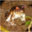

In [8]:
# visualize image
image, label = train_dataset[0]
print(f"label: {label}")
image.show()

UPT is designed for irregular grid data, so we make some small adjustments to do image classification:
- instead of the supernode pooling (which requires irregular grid data) we use a ViT patch embedding to handle images
- instead of the Perceiver Decoder (which decodes the latent space per position), we instead classify the latent space
into 10 classes by averaging all latent tokens and then using a linear classifier

In [9]:
from upt.models.encoder_image import EncoderImage
encoder = EncoderImage(
    # CIFAR has 3 channels (RGB)
    input_dim=3,
    # CIFAR has 32x32 images -> patch_size=4 results in 64 patch tokens
    resolution=32,
    patch_size=4,
    # ViT-T latent dimension
    enc_dim=192,
    enc_num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    enc_depth=4,
    # the perceiver is optional, it changes the size of the latent space to NUM_LATENT_TOKENS tokens
    # perc_dim=dim,
    # perc_num_heads=num_heads,
    # num_latent_tokens=32,
)

# we can now encode images
image, label = train_dataset[0]
# convert image to a tensor
from torchvision.transforms import ToTensor
tensor = ToTensor()(image).unsqueeze(0)
encoded_image = encoder(tensor)
print(f"encoded_image.shape: {encoded_image.shape}")

encoded_image.shape: torch.Size([1, 64, 192])


In this setting, we dont really need an approximator, but we'll keep it for consistency.

In [10]:
from upt.models.approximator import Approximator
approximator = Approximator(
    # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
    input_dim=192,
    # as in ViT-T
    dim=192,
    num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    depth=4,
)

approximator_output = approximator(encoded_image)
print(f"approximator_output.shape: {approximator_output.shape}")

approximator_output.shape: torch.Size([1, 64, 192])


The decoder now only uses some transformers, then averages all tokens and classifies the image with a simple linear
head.

In [11]:
from upt.models.decoder_classifier import DecoderClassifier
decoder = DecoderClassifier(
    # tell the decoder the dimension of the input (dim of approximator)
    input_dim=192,
    # CIFAR10 has 10 classes
    num_classes=10,
    # as in ViT-T
    dim=192,
    num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    depth=4,
)
prediction = decoder(approximator_output)
print(f"prediction.shape: {prediction.shape}")
print(f"decoder predicted class: {prediction.argmax(dim=1)}")

prediction.shape: torch.Size([1, 10])
decoder predicted class: tensor([9])


# Train a model
Now we can put it all together and train an image classifier.

In [12]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from tqdm import tqdm

from upt.models.approximator import Approximator
from upt.models.decoder_classifier import DecoderClassifier
from upt.models.encoder_image import EncoderImage
from upt.models.upt_image_classifier import UPTImageClassifier

# initialize dataset
transform = ToTensor()
train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

# hyperparameters
dim = 192  # ~6M parameter model
num_heads = 3
epochs = 10
batch_size = 256

# initialize model
model = UPTImageClassifier(
    encoder=EncoderImage(
        # CIFAR has 3 channels (RGB)
        input_dim=3,
        # CIFAR has 32x32 images -> patch_size=4 results in 64 patch tokens
        resolution=32,
        patch_size=4,
        # ViT-T latent dimension
        enc_dim=dim,
        enc_num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        enc_depth=4,
        # the perceiver is optional, it changes the size of the latent space to NUM_LATENT_TOKENS tokens
        # perc_dim=dim,
        # perc_num_heads=num_heads,
        # num_latent_tokens=32,
    ),
    approximator=Approximator(
        # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
        input_dim=dim,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
    ),
    decoder=DecoderClassifier(
        # tell the decoder the dimension of the input (dim of approximator)
        input_dim=dim,
        # CIFAR10 has 10 classes
        num_classes=10,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

# setup dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
total_updates = len(train_dataloader) * epochs
warmup_updates = int(total_updates * 0.1)
lrs = torch.concat(
    [
        # linear warmup
        torch.linspace(0, optim.defaults["lr"], warmup_updates),
        # linear decay
        torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
    ],
)

# train model
update = 0
pbar = tqdm(total=total_updates)
pbar.update(0)
pbar.set_description("train_loss: ????? train_accuracy: ????% test_accuracy: ????%")
test_accuracy = 0.0
train_losses = []
train_accuracies = []
test_accuracies = []
loss = None
train_accuracy = None
for _ in range(epochs):
    # train for an epoch
    for x, y in train_dataloader:
        # prepare forward pass
        x = x.to(device)
        y = y.to(device)

        # schedule learning rate
        for param_group in optim.param_groups:
            param_group["lr"] = lrs[update]

        # forward pass
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)

        # backward pass
        loss.backward()

        # update step
        optim.step()
        optim.zero_grad()

        # status update
        train_accuracy = ((y_hat.argmax(dim=1) == y).sum() / y.numel()).item()
        update += 1
        pbar.update()
        pbar.set_description(
            f"train_loss: {loss.item():.4f} "
            f"train_accuracy: {train_accuracy * 100:4.1f}% "
            f"test_accuracy: {test_accuracy * 100:4.1f}%"
        )
        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy)

    # evaluate
    num_correct = 0
    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_hat = model(x)
        num_correct += (y_hat.argmax(dim=1) == y).sum().item()
    test_accuracy = num_correct / len(test_dataset)
    test_accuracies.append(test_accuracy)
    pbar.set_description(
        f"train_loss: {loss.item():.4f} "
        f"train_accuracy: {train_accuracy * 100:4.1f}% "
        f"test_accuracy: {test_accuracy * 100:4.1f}%"
    )
pbar.close()

parameters: 5.4M


train_loss: 0.6893 train_accuracy: 76.6% test_accuracy: 65.2%: 100%|██████████| 1950/1950 [01:24<00:00, 23.00it/s]


Lets plot the learning curves

In [14]:
model

UPTImageClassifier(
  (encoder): EncoderImage(
    (patch_embed): VitPatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): Identity()
    )
    (pos_embed): VitPosEmbed2d()
    (blocks): Sequential(
      (0): PrenormBlock(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): DotProductAttention1d(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
        )
        (ls1): Identity()
        (drop_path1): DropPath(drop_prob=0.000)
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
        )
        (ls2): Identity()
        (drop_path2): DropPath(drop_prob=0.000)
      )
      (1): PrenormBlock(
        (norm1)

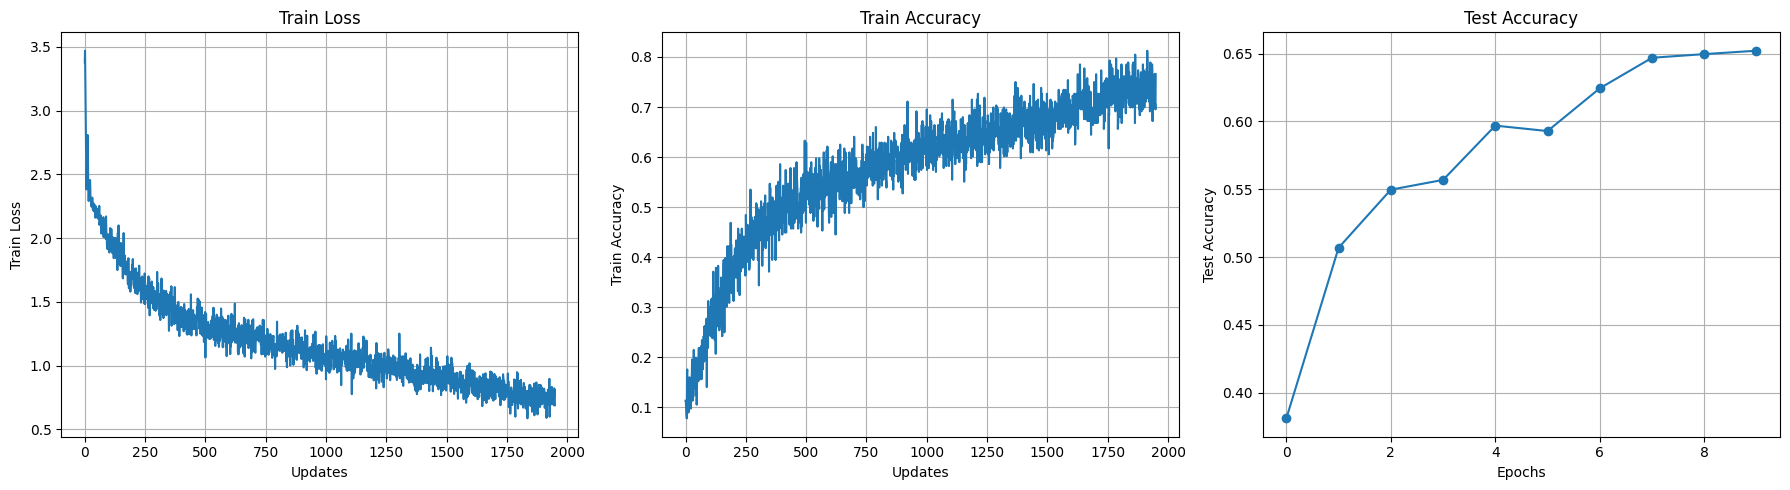

In [13]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(range(len(train_losses)), train_losses)
axes[0].set_xlabel("Updates")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Train Loss")
axes[0].grid(True)
axes[1].plot(range(len(train_accuracies)), train_accuracies)
axes[1].set_xlabel("Updates")
axes[1].set_ylabel("Train Accuracy")
axes[1].set_title("Train Accuracy")
axes[1].grid(True)
axes[2].plot(range(len(test_accuracies)), test_accuracies, marker="o")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Test Accuracy")
axes[2].set_title("Test Accuracy")
axes[2].grid(True)
plt.tight_layout()
plt.show()

Not the best classifier, but you know: it works! There are of course a lot of things (augmentations, longer training, better hyperparameters) that would improve classification performance but it should show you the basics of UPT.